# Survey_statistics

Survey feature map's mean & std for each layer in model, for epoch in train-process.

In [1]:
from typing import Optional
from itertools import product
import importlib

import torch
from ignite.engine import create_supervised_evaluator
from ignite.utils import manual_seed
import ignite.distributed as idist

from analyze import *
from architectures.train import get_dataloader

manual_seed(123)

## get data

In [2]:
def survey_statistics(experiment_dir: str, epochs: Optional[list], layernames: Optional[list]):
    module = importlib.import_module(f'experiments.{experiment_dir.replace("/", ".")}.architectures.common.components_common')
    
    dataloader = get_dataloader({
        "dataloader": {
            "dataset": "ImageNet",
            "train_loader_params": {"batch_size": 128, "num_workers": 8, "shuffle": True,  "pin_memory": True}, # don't care;
            "eval_loader_params":  {"batch_size": 128, "num_workers": 8, "shuffle": False, "pin_memory": True}
        }
    })['eval']
    
    epochs = epochs if epochs is not None else [epoch in epoch in range(0, 90 + 1, 5)]
    
    data = {epoch: {layername: None for layername in layernames} for epoch in epochs}
    def extract_feature_map(epoch, layername):
        def hook(M, I, O):
            data[epoch][layername] = O.detach().cpu()
        return hook
                
    for epoch in epochs:
        model, exp_config = load_model(experiment_dir, epoch)
        model = model.to(idist.device())
        #model = idist.auto_model(model)
        evaluator = create_supervised_evaluator(model, device=idist.device())
        
        if layernames is None:
            layernames = []
            for layername, m in model.named_modules():
                if isinstance(m, module.QuantPACTReLU):
                    layernames.append(layername)
        
        handles = []
        for layername, m in model.named_modules():
            if isinstance(m, module.QuantPACTReLU) and layername in layernames:
                handles.append(m.register_forward_hook(extract_feature_map(epoch, layername)))
                
        evaluator.run(dataloader, max_epochs=1, epoch_length=1)
        
        for handle in handles:
            handle.remove()
    
    return data

In [3]:
experiment_dir = 'EoQ - ResNet18+ImageNet/13'
epochs = [5, 50, 90]
layernames = ['layer1.0.relu1', 'layer2.0.relu2']

data = survey_statistics(experiment_dir, epochs, layernames)

2021-06-29 15:11:50,508 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset ImageFolder': 
	{'batch_size': 128, 'num_workers': 8, 'shuffle': True, 'pin_memory': True}
2021-06-29 15:11:50,511 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset ImageFolder': 
	{'batch_size': 128, 'num_workers': 8, 'shuffle': False, 'pin_memory': True}


## data visualize

epoch: 5, layername: layer1.0.relu1


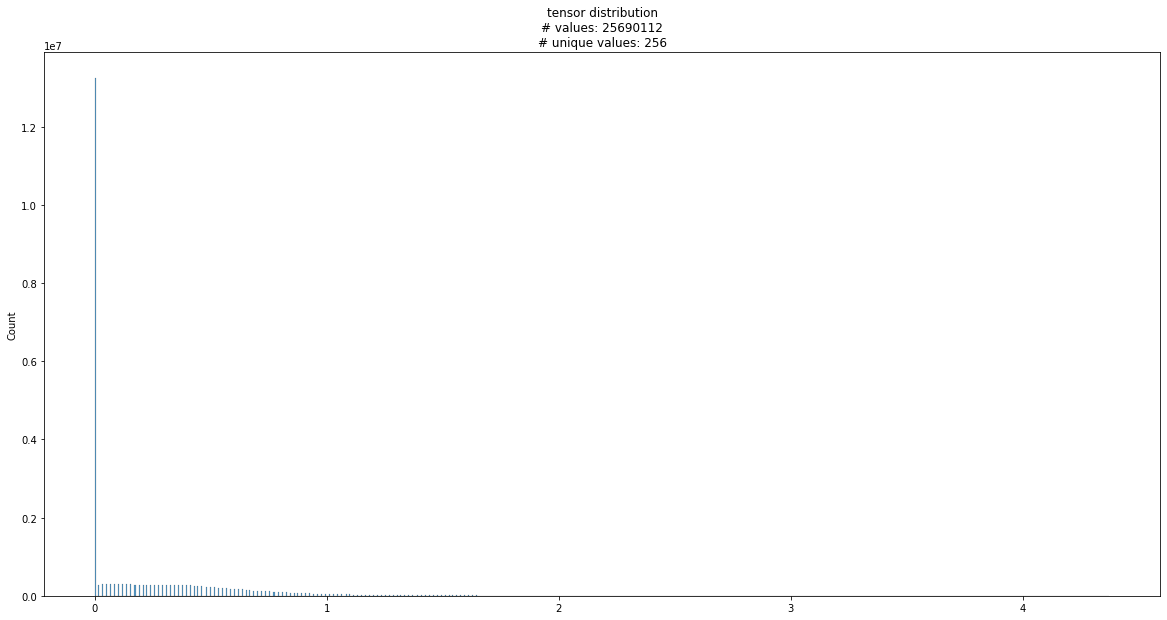

epoch: 5, layername: layer2.0.relu2


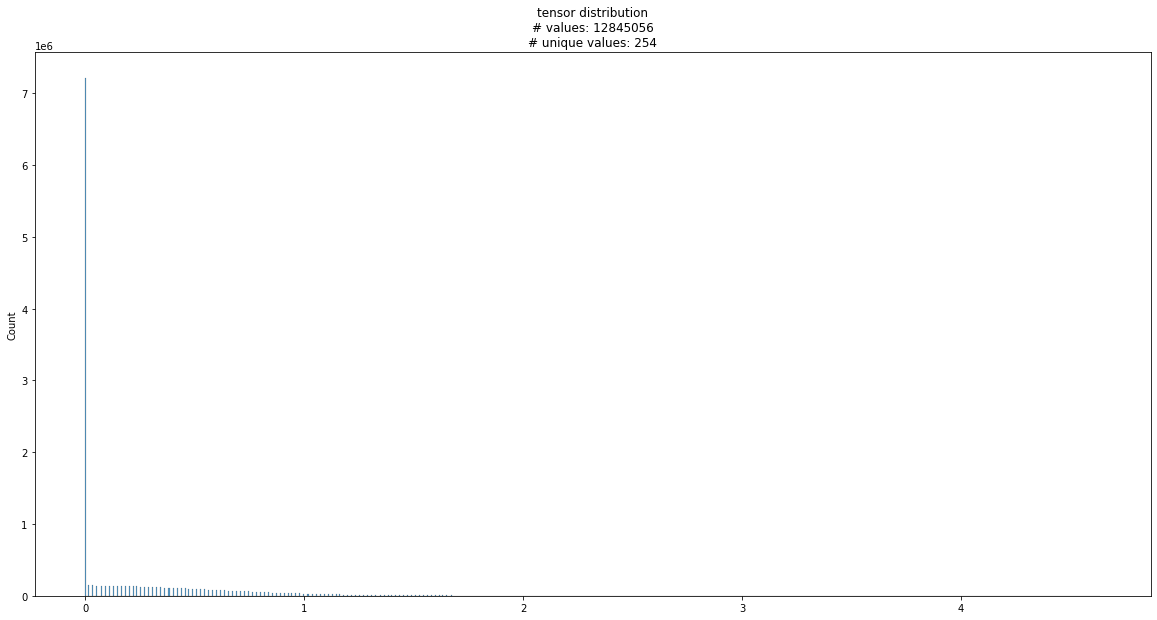

epoch: 50, layername: layer1.0.relu1


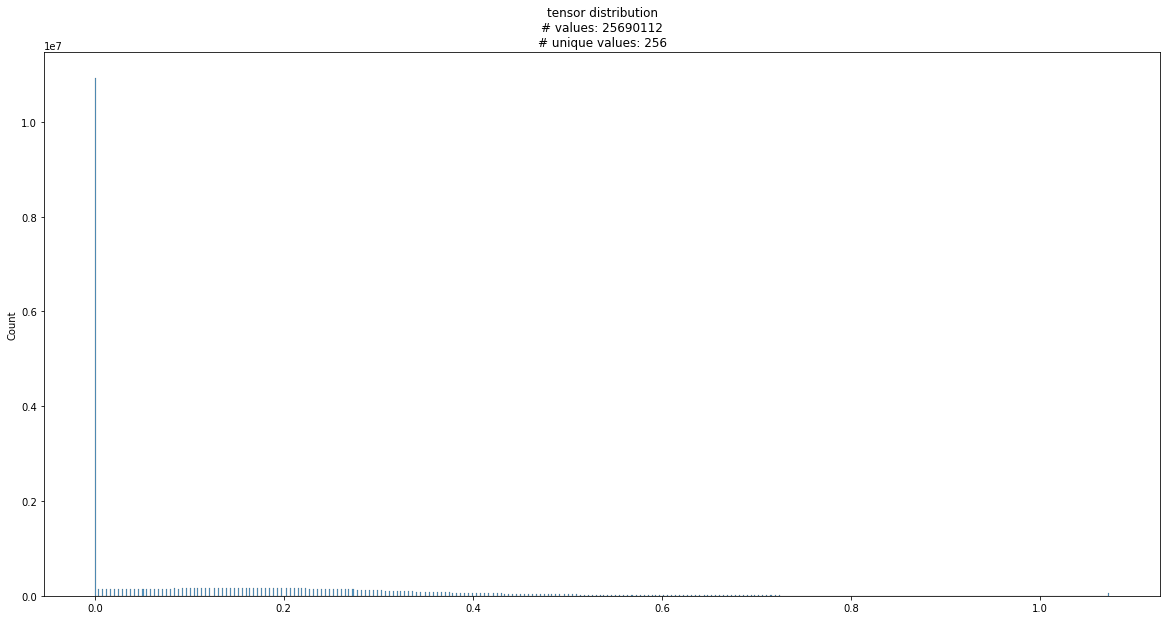

epoch: 50, layername: layer2.0.relu2


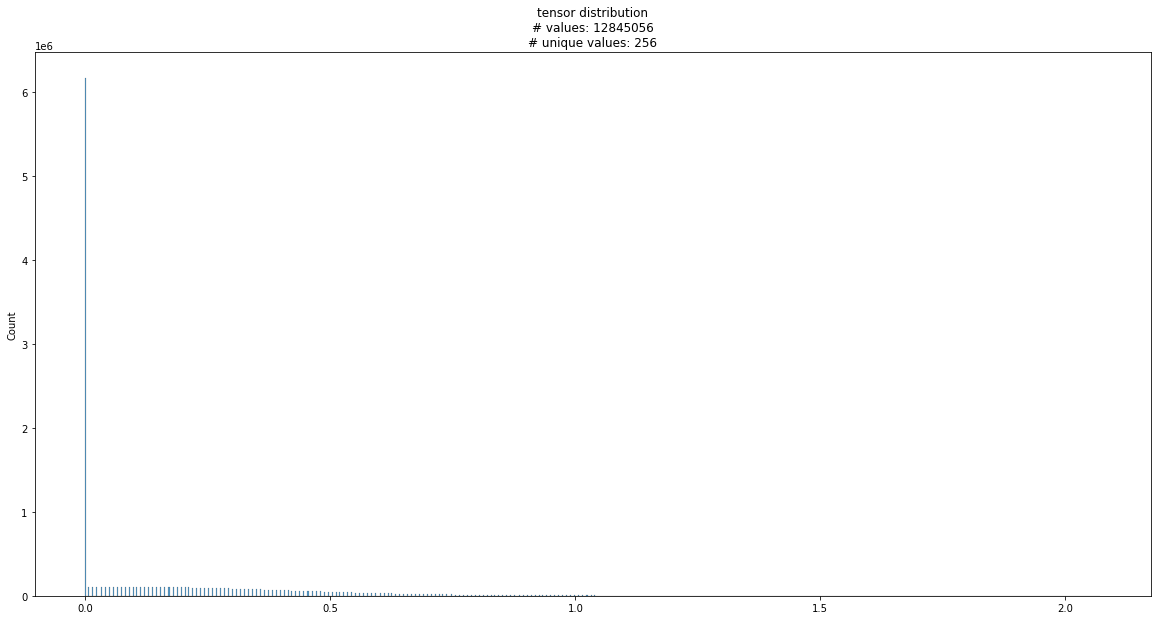

epoch: 90, layername: layer1.0.relu1


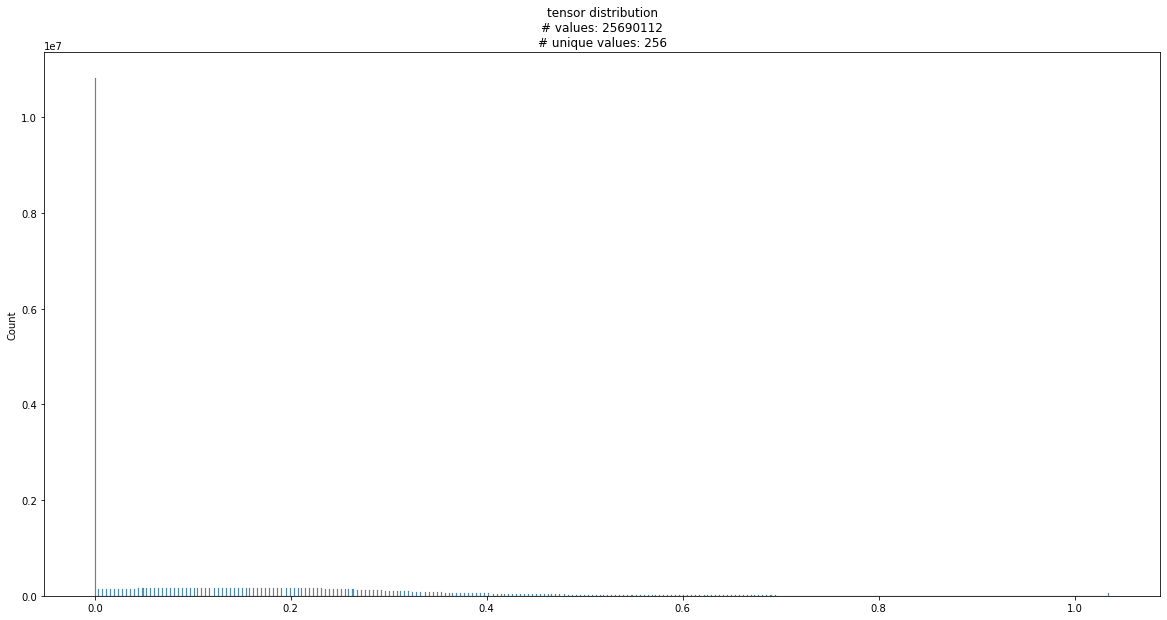

epoch: 90, layername: layer2.0.relu2


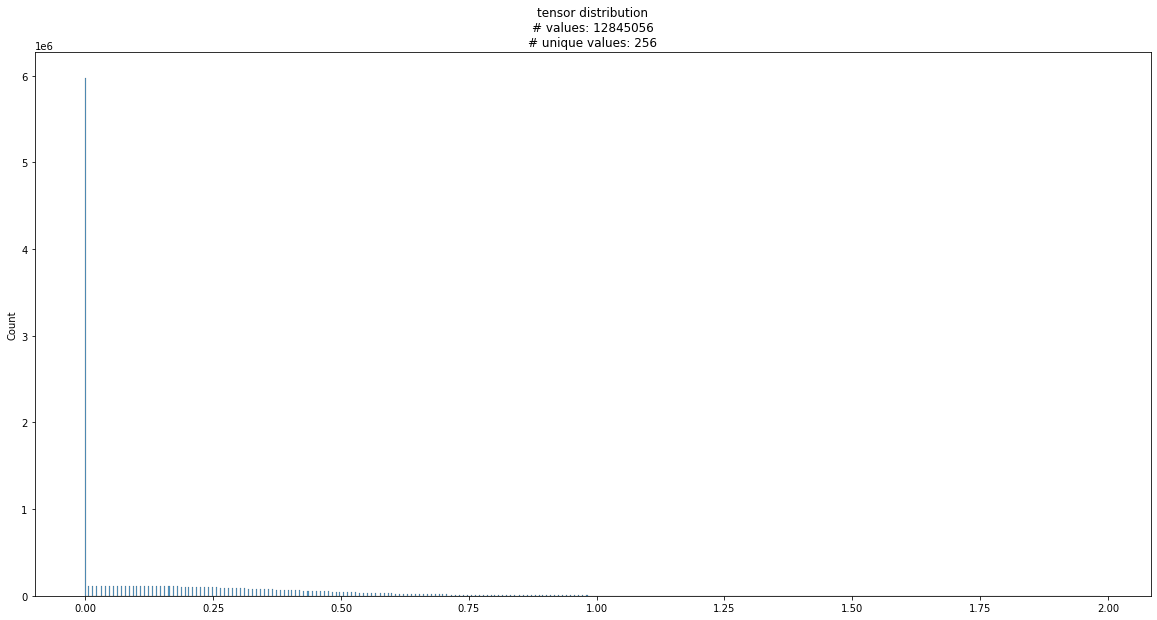

In [6]:
for (epoch, layername) in product(epochs, layernames):
    tensor = data[epoch][layername]
    
    print(f'epoch: {epoch}, layername: {layername}')
    visualize_tensor_distribution(tensor)